Load dataset

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

gold_df = pd.read_csv("reduced_datasets/gold_reduced.csv")

# ensure datetime
gold_df['Assessment_Date'] = pd.to_datetime(
    gold_df['Assessment_Date'],
    errors='coerce'
)

gold_df.head()

,Student_ID,Course_Code,Mark,Assessment_Date,Academic_Year,Semester,Attendance_Rate,Campus_ID,Mark_scaled,Attendance_Rate_scaled,...,Assessment_Type_Summative,Performance_Band,Gender,DOB,Program,Level,Intake_Year,Course_Title,Credits,Campus_Name
0,HUY-26125,CS104,66.5,2023-06-16,2024/2025,1,0.8,HUY-26,0.058121,0.109766,...,0,Credit,Female,2023-03-22,SOFTWARE ENG,1,2024,Machine Learning,4.0,Huye
1,HUY-26118,CS103,62.0,2023-01-08,2024/2025,2,0.6,HUY-26,-0.429581,-1.198281,...,1,Pass,Female,2023-03-22,INFORMATION TECH,2,2023,Cyber security,3.0,Huye
2,HUY-26115,CS101,69.0,2023-01-08,2024/2025,1,0.6,HUY-26,0.329067,-1.198281,...,1,Credit,Female,2023-03-22,DATA SCIENCE,3,2022,Programming,3.0,Huye
3,HUY-26107,CS102,66.5,2023-01-08,2024/2025,2,0.8,HUY-26,0.058121,0.109766,...,0,Credit,Female,2023-12-31,SOFTWARE ENG,1,2022,Databases,4.0,Huye
4,HUY-26105,CS101,58.0,2023-01-08,2024/2025,2,1.0,HUY-26,-0.863094,1.417813,...,1,Pass,Female,2023-03-22,INFORMATION TECH,3,2024,Programming,3.0,Huye


A) Date-Time Features

In [2]:
# Month of assessment
gold_df['assessment_month'] = gold_df['Assessment_Date'].dt.month

# Day of week (0=Mon, 6=Sun)
gold_df['assessment_weekday'] = gold_df['Assessment_Date'].dt.dayofweek

# Weekend flag
gold_df['is_weekend_assessment'] = (
    gold_df['assessment_weekday'].isin([5, 6])
).astype(int)

print("Date features created!")

Date features created!


B) Student Performance Aggregations

In [3]:
student_group = gold_df.groupby('Student_ID')

gold_df['student_course_count'] = student_group['Course_Code'].transform('count')
gold_df['student_avg_mark'] = student_group['Mark'].transform('mean')
gold_df['student_max_mark'] = student_group['Mark'].transform('max')

# Fail count
gold_df['student_fail_count'] = student_group['Performance_Band']\
    .transform(lambda x: (x == 'Fail').sum())

# Credits earned
gold_df['student_total_credits_earned'] = student_group['Credits'].transform('sum')

print("Student performance features created!")

Student performance features created!


C) Risk Flags (Rule-Based)

In [4]:
# At-risk students
gold_df['is_at_risk'] = (
    (gold_df['student_avg_mark'] < 50) |
    (gold_df['student_fail_count'] >= 2)
).astype(int)

# Low attendance
gold_df['low_attendance_flag'] = (
    gold_df['Attendance_Rate'] < 0.75
).astype(int)

print("Risk flags created!")

Risk flags created!


Save Final Dataset

In [ ]:
os.makedirs("feature_datasets", exist_ok=True)

feature_path = "feature_datasets/gold_features.csv"
gold_df.to_csv(feature_path, index=False)

print("Feature dataset saved:", feature_path)
gold_df.head()


Feature dataset saved: feature_datasets/gold_features.csv


,Student_ID,Course_Code,Mark,Assessment_Date,Academic_Year,Semester,Attendance_Rate,Campus_ID,Mark_scaled,Attendance_Rate_scaled,...,assessment_month,assessment_weekday,is_weekend_assessment,student_course_count,student_avg_mark,student_max_mark,student_fail_count,student_total_credits_earned,is_at_risk,low_attendance_flag
0,HUY-26125,CS104,66.5,2023-06-16,2024/2025,1,0.8,HUY-26,0.058121,0.109766,...,6,4,0,1,66.500000,66.50,0,4.0,0,0
1,HUY-26118,CS103,62.0,2023-01-08,2024/2025,2,0.6,HUY-26,-0.429581,-1.198281,...,1,6,1,1,62.000000,62.00,0,3.0,0,1
2,HUY-26115,CS101,69.0,2023-01-08,2024/2025,1,0.6,HUY-26,0.329067,-1.198281,...,1,6,1,2,65.500000,69.00,0,6.0,0,1
3,HUY-26107,CS102,66.5,2023-01-08,2024/2025,2,0.8,HUY-26,0.058121,0.109766,...,1,6,1,3,67.250000,73.25,0,10.0,0,0
4,HUY-26105,CS101,58.0,2023-01-08,2024/2025,2,1.0,HUY-26,-0.863094,1.417813,...,1,6,1,3,62.166667,66.50,0,10.0,0,0


Missing Values Chart

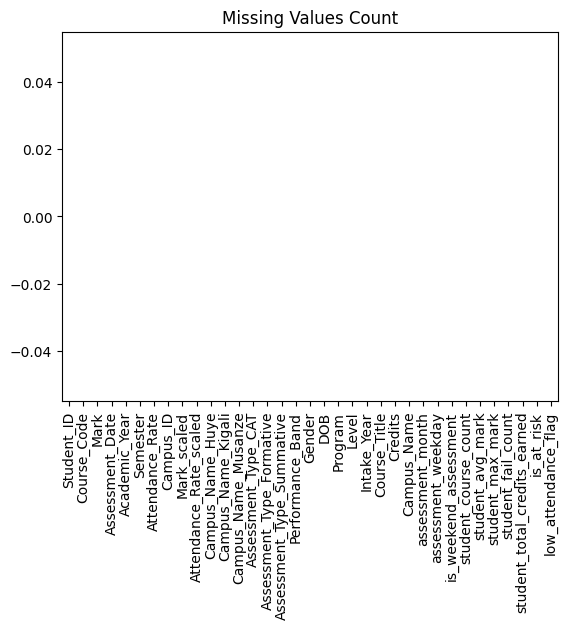

In [ ]:
gold_df.isnull().sum().plot(kind='bar')
plt.title("Missing Values Count")
plt.show()

Marks Distribution

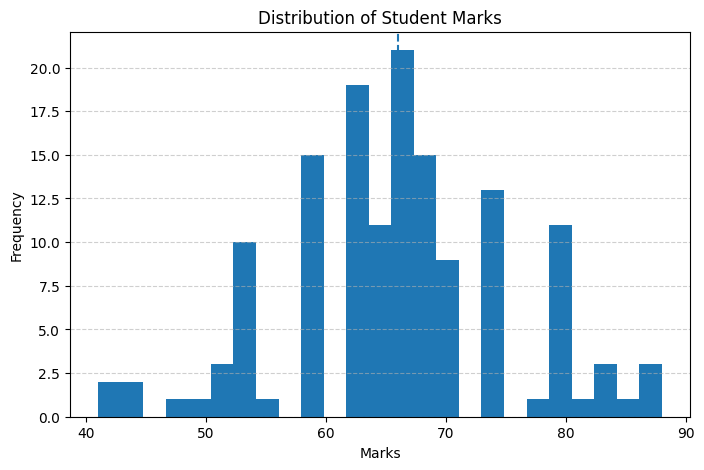

In [ ]:
plt.figure(figsize=(8,5))

gold_df['Mark'].plot(kind='hist', bins=25)

plt.axvline(gold_df['Mark'].mean(), linestyle='--')
plt.title("Distribution of Student Marks")
plt.xlabel("Marks")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

At-Risk Students by Campus

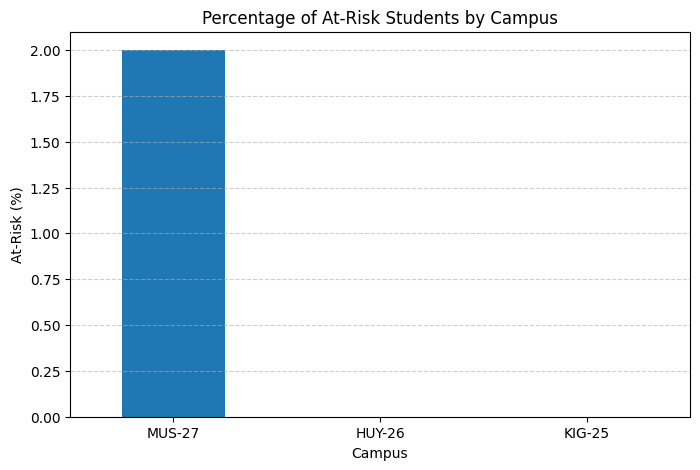

In [ ]:
risk_rate = gold_df.groupby('Campus_ID')['is_at_risk'].mean() * 100
risk_rate = risk_rate.sort_values(ascending=False)

plt.figure(figsize=(8,5))

risk_rate.plot(kind='bar')

plt.title("Percentage of At-Risk Students by Campus")
plt.ylabel("At-Risk (%)")
plt.xlabel("Campus")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=0)

plt.show()

Comparison of performance

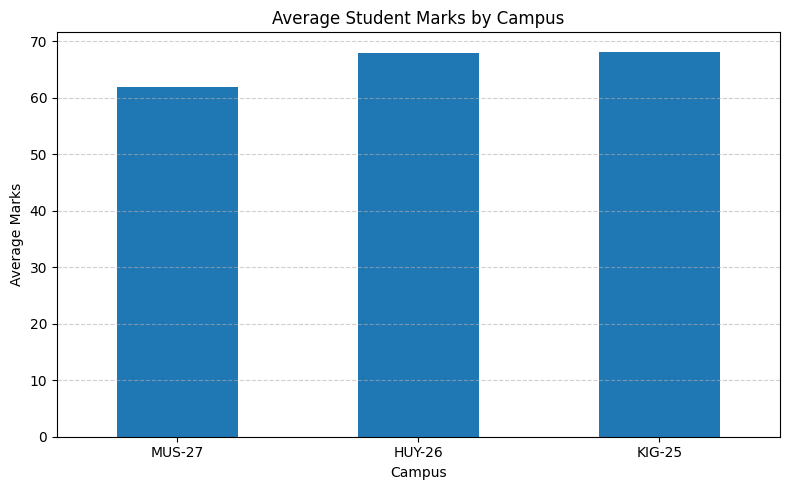

In [ ]:
campus_mean = gold_df.groupby('Campus_ID')['Mark'].mean().sort_values()

plt.figure(figsize=(8,5))
campus_mean.plot(kind='bar')

plt.title("Average Student Marks by Campus")
plt.xlabel("Campus")
plt.ylabel("Average Marks")

plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()